# Space Launches Dataset Exploration

The number of space launches and satellites in orbit has increased drastically in the last few years, and we would like to see how marked that trend is compared to previous decades.

We'll be exploring launch data from the [Gunter Space Page](https://space.skyrocket.de/directories/chronology.htm), that Gunter kindly authorized me for using. In the Chronology section, we have every space launch for the year, with a list of payloads the launch carried. After a quick analysis of the columns in the dataset and some cleaning on the columns with useful information, we'll create some visualizations and answer some questions.

Each of our rows of our dataset will have a "payload" (something that was put in orbit, hopefully, or was lost if the launch failed), in a launch. Each launch has a unique ID. Let's see what other columns we have. (this dataset was partially cleaned for simplicity beforehand)

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
df = pd.read_csv("../input/spacelaunches/clean_launch_data.csv")
df.head()

,nation,type / application,operator,contractors,equipment,configuration,propulsion,power,lifetime,mass,orbit,date,id,vehicle,site,failed,"type, application"
0,ussr,technology,NaN,npo energia,2 transmitters,pressurized sphere with four antennas,none,batteries,21 days,84 kg,"228 km × 947 km, 65.0�",1957-10-04T03:00:00.000Z,1957 α (001),Sputnik (1),Ba LC-1/5,False,NaN
1,ussr,biological resaerch,NaN,NaN,NaN,r-7 core with added payload,none (after burnout),batteries,6 days,508 kg (payload),"212 km × 1660 km, 65.3�",1957-11-03T03:00:00.000Z,1957 β (002),Sputnik (1),Ba LC-1/5,False,NaN
2,usa,science,nasa,naval research laboratory (nrl),NaN,NaN,none,"solar cells, batteries",NaN,1.5 kg,"654 km × 3969 km, 34.25�",1957-12-06T03:00:00.000Z,1957-F01,Vanguard,CC LC-18A,True,NaN
3,usa,"research, magnetosphere, micro meteorites",nasa,jet propulsion laboratory (jpl),"cosmic-ray detection package, temperature sens...",aerodynimcally shaped satellite body attached ...,none,batteries,NaN,"14 kg (#1-3), 17 kg (#4-5)","356 km × 2548 km, 33.24� (#1); 186 km × 2799 k...",1958-02-01T03:00:00.000Z,1958 α (001),Juno-1,CC LC-26A,False,NaN
4,usa,science,nasa,naval research laboratory (nrl),NaN,NaN,none,"solar cells, batteries",NaN,1.5 kg,"654 km × 3969 km, 34.25�",1958-02-05T03:00:00.000Z,1958-F01,Vanguard,CC LC-18A,True,NaN


For each payload, the row indicates what country it belongs to ("nation"). But that's not necessarily the country from where the payload was launched. That information is part of the "site" column. More information here: the vehicle that was used in the launch, and if the launch was successful.

Besides that, we know the type of the satellite, contractor, configuration, mass, the equipment the satellite carries, the propulsion method it uses, how it is powered, its expected lifetime, and mass. Many of the columns need some cleaning so we won't concern ourselves a lot with them. Let's see which of the columns will be most useful

In [3]:
df.describe()

,nation,type / application,operator,contractors,equipment,configuration,propulsion,power,lifetime,mass,orbit,date,id,vehicle,site,failed,"type, application"
count,9304,9165,6994,8189,5217,6339,6891,9088,4237,7140,6768,9359,9359,9359,9359,9359,137
unique,176,506,1067,1072,1139,686,349,125,392,1383,1612,5247,5956,497,207,2,6
top,usa,communication,gru,tsskb,?,cubesat (3u),?,"solar cells, batteries",~ 1 year (iss orbit); 2-3 years (sso),~260 kg,geo,2017-02-15T03:00:00.000Z,2017-008,Soyuz-U,CC SLC-40,False,"earth observation, traffic monitoring"
freq,3753,1821,870,750,961,709,1729,2372,383,478,1219,104,104,796,575,8566,111


As we gathered from peeking at the first rows, most of the columns need more cleaning in order to be useful: there are many unique values (power, contractor, type of the satellite), so we won't be able to make much sense of them without more work: there seem to be 349 different types of propulsion and power configurations, the "type / application column" seems to be indicated as "type , application" in some cases and as "type / application" in others. 

Looking at the equipment column, it's easy to tell it needs much more work. It won't used for now. Instead, we'll focus on columns regarding the launch to get a sense of long term trends in the access countries have been gaining to space, and leave the information about individual payloads for some other time.


In [4]:
df["equipment"].dropna().value_counts().head(30)
#Best stay away from this for now!

?                                                                                                         961
ku/ka-band payload, optical inter-satellite link                                                          478
ps0, ps1 or ps2 imaging payload                                                                           383
ku-band payload                                                                                           129
see above                                                                                                 117
stratos (gps radio occultation payload), sense (ais-receiver), airsafe (asd-b payload, #78 and later)     111
package                                                                                                    96
ftor-2 camera package, kust-12m elint package                                                              81
ftor-4 camera package                                                                                      76
l-band pay

In [5]:
#Fixing the type / application column
df["type"] = df["type / application"].fillna("").astype(str)  +df["type, application"].fillna("").astype(str) 
df = df.drop(["type / application","type, application"], axis = 1)
df.head()

df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# First analysis - number of launches, and success rate

We'll plot how many launches took place each year, regardless of how many payloads it was carrying, to see if the data makes sense. For that, since the dataset has a row for each payload, we'll first grab the year and id column, and determine the number of separate space launches each year using groupby.

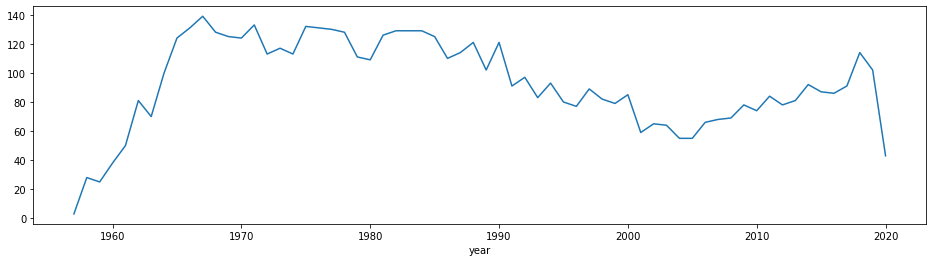

In [6]:
#on "id" we have the id of the launch. We'll only keep those two columns, and drop the duplicates to get the unique launches each year.
per_year_df = df[ ["year","id"] ].drop_duplicates()
#Now, we group by year, get the size, and with that plot the number of launches.
per_year_df.groupby("year").size().plot(kind="line",figsize=(16,4))

Interestingly enough, launches have indeed become more frequent lately, but are still far from the peak in the Cold War. If we plot the total number of launches each decade, the 70s and 80s are the most active. That information seems to make sense. We also see that for 2020 we have a drop in the number of launches, since the year is not done yet.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fae0d200150>]],
      dtype=object)

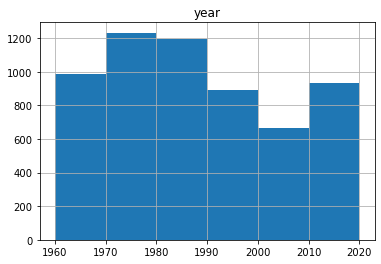

In [7]:
per_year_df.hist(bins=[1960,1970,1980,1990,2000,2010,2020])

Let's take a closer look now at the success and the failures of the launches. For that, we'll grab the id and failed column of our dataset, and add the number of items launched into space, using size and groupby. 

In [8]:
#Failure Rate, another plot in the same showing failure trend
per_year_df = df[ ["year","id","failed"] ].drop_duplicates()
per_year_df.head()

,year,id,failed
0,1957,1957 α (001),False
1,1957,1957 β (002),False
2,1957,1957-F01,True
3,1958,1958 α (001),False
4,1958,1958-F01,True


Now, plot them to see the percentage of successful launches each year. For that it will be necessary to re-arrange our data set, and add a success rate column.

In [9]:
failures_per_year = per_year_df.groupby(["year","failed"]).size().unstack().reset_index();
failures_per_year["success"] = (failures_per_year[False])
failures_per_year["failures"] = (failures_per_year[True])
failures_per_year["total_launches"] = (failures_per_year[True]+failures_per_year[False])
failures_per_year["success_rate"] = 100*failures_per_year[False]/failures_per_year["total_launches"]
failures_per_year = failures_per_year[ ["year","success","failures","total_launches","success_rate"] ]

#failures_per_year.tail(10)

success_year= pd.melt(failures_per_year,id_vars=["year"],value_vars=["total_launches","failures","success_rate"],var_name="variable")

#success_year.tail(10)

 "Melt" is used to unpivot our data, turning "success","failures", and "success_rate" columns to values of a single column, named variable, in order to use a grid and analyze each of these variables separately.


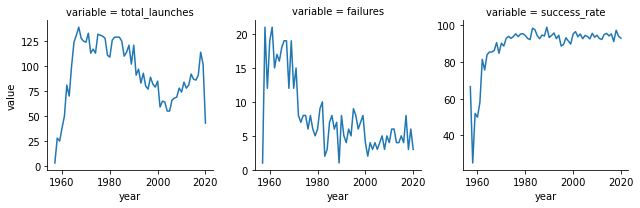

In [10]:
facets = sns.FacetGrid(success_year, col="variable",sharex=False,sharey=False)
facets.map(sns.lineplot,"year","value")

As one would expect, success rate has increased a lot since the first few years, and is around 90-95% in these last few years. With our first global view done, let's try and turn our attention to this same information, but looking at the countries launching these satellites, and taking a closer look at the payload being put into orbit.

# Launch Sites - Cleaning, and joining

Let's now take a look at our site information. It indicates the country where the launch site is located, it has a code, and a "details" column. "suo" indicates it's a Suborbital Launch Site, and orb that it is an orbital launch site. The "t" at the end indicates the launch site (https://space.skyrocket.de/directories/launchsites.htm) The rest is probable left over html from web scrapping.

In [11]:
sites = pd.read_json("../input/spacelaunches/sites.json")
sites.head(25)

,country,raw,details,code,name
0,Algeria,Ha= Centre interarmées d’essais d’engins spéc...,suo,Ha,Centre interarmées d’essais d’engins spéciau...
1,Algeria,"Reg= Reggane, Adrar Province",suo,Reg,"Reggane, Adrar Province"
2,Antarctica,"DdU= Dumont d'Urville Station, Terre Adelie †",suot,DdU,"Dumont d'Urville Station, Terre Adelie †"
3,Antarctica,"Mat= Base Aerea Teniente Benjamin Matienzo, N...",suot,Mat,"Base Aerea Teniente Benjamin Matienzo, Nunat..."
4,Antarctica,"McM= McMurdo Station, Ross Ice Shelf, New Zea...",suot,McM,"McMurdo Station, Ross Ice Shelf, New Zealand..."
5,Antarctica,"Mol= Molodezhnaya Station, Enderby Land, Aust...",suo,Mol,"Molodezhnaya Station, Enderby Land, Australi..."
6,Antarctica,"Rot= Rothera Research Station, British Antarc...",suot,Rot,"Rothera Research Station, British Antarctic ..."
7,Antarctica,"Sip= Siple Station, Ellsworth Land †",suot,Sip,"Siple Station, Ellsworth Land †"
8,Antarctica,"Sho= Showa Station (Syowa Station), East Ongu...",suot,Sho,"Showa Station (Syowa Station), East Ongul Is..."
9,Antarctica,"VcM= Vicecomodoro Marambio Station, Seymour I...",suot,VcM,"Vicecomodoro Marambio Station, Seymour Islan..."


The only useful information right now is in the country and the code, in order to join them to our launch dataset. We'll keep those columns, and build a new dataframe with the launch data. Tweaking the site column in our main dataframe will be necessary since it includes the launch pad (Ba LC 1/5, for instance)

In [12]:
df["site_code"] = df["site"].apply(lambda x: x.split(" ")[0]).astype("string")
print("Has null values? ", len(df["site_code"])!=len(df["site_code"].dropna()))
sites.set_index("code",inplace=True)

Has null values?  False


In order to properly join both datasets, we need to see if the site launch codes specified in our launch data matches the site code. 

In [13]:
#Check different values for the site codes.
launch_site_codes = set(df["site_code"].unique())
site_codes = set(sites.index.unique())
unmatched_codes = list(launch_site_codes-site_codes)
unmatched_codes

['',
 'Kw,',
 '@YS',
 'BaS',
 'SLC-36B',
 'CC,',
 'Mo,',
 'In,',
 'CCK',
 'Ga,',
 'Va,',
 'SLC-36A',
 '@BaS',
 'Ed,',
 'WI,']

Some are empty, some have commas, others seem to have capitalization issues, other include a @. Let's define a function to replace our simple "split" operation then, since the cleaning operation won't be as simple as we thought. We'll apply that function to the site column, and check again for unmatched values.

In [14]:
def clean_site_code(raw_site):
    return re.sub("@|,|-.*","",raw_site.split(" ")[0]).strip()

def unmatched_codes(launch_site_codes,site_codes):
    unmatched_code_list = list(set(launch_site_codes)-set(site_codes))
    return unmatched_code_list

In [15]:
df["site_code"] = df["site"].apply(clean_site_code).astype("string")
unmatched = unmatched_codes(df["site_code"].unique(),sites.index.unique())
df[df["site_code"].isin(unmatched)]["site_code"].value_counts()

CCK    473
YS       7
BaS      5
SLC      4
         1
Name: site_code, dtype: Int64

Almost done, but more information is needed about that CCK site, since it accounts for almost all of our missing values. Also, it's necessary to check for the rest of the missing values by visiting the page of the launch year.

In [16]:
#What payloads have incorrect launch sites (besides CCK)? With the year of the launch site, we'll revisit our source of the data.

df[ (df["site_code"].isin(unmatched)) & ( df["site_code"] != "CCK")][["year","site_code","site"]]

,year,site_code,site
4897,1998,BaS,BaS
4898,1998,BaS,BaS
4899,1998,BaS,BaS
5310,2002,,LC-1/5
5480,2004,SLC,SLC-36A
5484,2004,SLC,SLC-36B
5495,2004,SLC,SLC-36B
5517,2004,SLC,SLC-36A
5573,2005,BaS,@BaS
5648,2006,BaS,@BaS K-84


I went back to explore the source of the data, and checked the years with problematic launch sites. (https://space.skyrocket.de/doc_chr/lau2019.htm, https://space.skyrocket.de/doc_chr/lau1998.htm, etc) . CCK seems to correspond to Cape Canaveral. Since the "CCK" is listed as a Launch Site different from "CC", I'll manually add it to our sites list. There are only a few sites, it's reasonable to go over them one by one and review the other problematic launch codes. Remember the goal is to determine which country they belong to. "LC-1/5" and "SLC-x", appear to be space lauch complexes in Cape Canaveral. BaS seems to be Ba, and YS is China, not completely sure where. We'll add an entry for that site as well.

In [17]:
new_sites = [
    ["USA","NASA John F. Kennedy Space Center, Cape Canaveral, Florida, USA","orb","NASA John F. Kennedy Space Center, Cape Canaveral, Florida, USA"],
    ["China","Unknown, China","orb","Unknown, China"]
]
cck_ys = pd.DataFrame(new_sites
                   ,columns=["country","raw","details","name"],
                   index=["CCK","YS"])

sites = sites.append(cck_ys)

unmatched = unmatched_codes(df["site_code"].unique(),sites.index.unique())
df[df["site_code"].isin(unmatched)][["year","site_code"]]

#df.loc[df["site"]=="LC-1/5", "site_code" ] = "CC"
df.loc[df["site_code"]=="", "site_code" ] = "CC"
df.loc[df["site_code"]=="SLC", "site_code" ] = "CC"
df.loc[df["site_code"]=="BaS", "site_code" ] = "Ba"
#df[df["site_code"]=="SLC"]

print("Number of unmatched site codes: ", len(df[df["site_code"].isin(unmatched)][["year","site_code","site"]]))

Number of unmatched site codes:  0


0 unmatched site codes. Everything is in order to join both datasets.

In [18]:
joined = df.join(sites, on="site_code", lsuffix="site__")
joined.head()


,nation,operator,contractors,equipment,configuration,propulsion,power,lifetime,mass,orbit,...,site,failed,type,year,month,site_code,country,raw,details,name
0,ussr,NaN,npo energia,2 transmitters,pressurized sphere with four antennas,none,batteries,21 days,84 kg,"228 km × 947 km, 65.0�",...,Ba LC-1/5,False,technology,1957,10,Ba,Kazakhstan,"Ba= Baikonur (Tyuratam, NIIP-5, GIK-5), Tyuratam",orb,"Baikonur (Tyuratam, NIIP-5, GIK-5), Tyuratam"
0,ussr,NaN,npo energia,2 transmitters,pressurized sphere with four antennas,none,batteries,21 days,84 kg,"228 km × 947 km, 65.0�",...,Ba LC-1/5,False,technology,1957,10,Ba,USSR / Russia,"Ba= Baikonur (Tyuratam, NIIP-5, GIK-5), Tyuratam",orb,"Baikonur (Tyuratam, NIIP-5, GIK-5), Tyuratam"
1,ussr,NaN,NaN,NaN,r-7 core with added payload,none (after burnout),batteries,6 days,508 kg (payload),"212 km × 1660 km, 65.3�",...,Ba LC-1/5,False,biological resaerch,1957,11,Ba,Kazakhstan,"Ba= Baikonur (Tyuratam, NIIP-5, GIK-5), Tyuratam",orb,"Baikonur (Tyuratam, NIIP-5, GIK-5), Tyuratam"
1,ussr,NaN,NaN,NaN,r-7 core with added payload,none (after burnout),batteries,6 days,508 kg (payload),"212 km × 1660 km, 65.3�",...,Ba LC-1/5,False,biological resaerch,1957,11,Ba,USSR / Russia,"Ba= Baikonur (Tyuratam, NIIP-5, GIK-5), Tyuratam",orb,"Baikonur (Tyuratam, NIIP-5, GIK-5), Tyuratam"
2,usa,nasa,naval research laboratory (nrl),NaN,NaN,none,"solar cells, batteries",NaN,1.5 kg,"654 km × 3969 km, 34.25�",...,CC LC-18A,True,science,1957,12,CC,USA,"CC= Cape Canaveral Air Force Station, Eastern...",orb,"Cape Canaveral Air Force Station, Eastern Te..."


There's a bit of a situation here. Launchpads that are in what was the Soviet Union are listed twice apparently. Ideally, we'd like to consider the country as "USSR" if the launch was before it collapsed. We'll need to determine when our data first registers "Russia" or another ex-USSR country, establish that as the "collapse_date" of the Soviet Union, and modify our sites dataset accordingly.

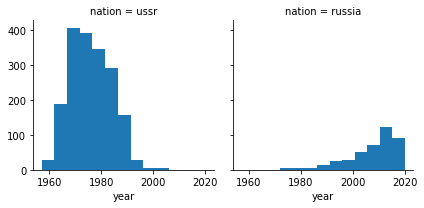

In [19]:
ussr_df = df[(df["nation"] == "russia") | (df["nation"] == "ussr")][ ["year","nation"] ]
grid = sns.FacetGrid(ussr_df,col="nation")
grid.map(plt.hist,"year")

Apparently that won't do. Some satellites are considered to be from "Russia" in the the 80s, and some are considered soviet well into the 90s. Remember, the data isn't perfect. So we'll say the launch sites belong to the USSR for dates before the dissolution of the Soviet Union. Another thing to do is finding other ambiguous site codes and fix them.

In [20]:
sites.reset_index().head()
#sites[sites["country"].str.contains("USSR") | sites["country"].str.contains("Uzb")]
sites.reset_index().groupby("index").filter(lambda x: len(x) > 1)


,index,country,raw,details,name
85,Ba,Kazakhstan,"Ba= Baikonur (Tyuratam, NIIP-5, GIK-5), Tyuratam",orb,"Baikonur (Tyuratam, NIIP-5, GIK-5), Tyuratam"
121,Sin,North Korea,"Sin= Sinpo Shipyard, South Hamgyong Province",mis,"Sinpo Shipyard, South Hamgyong Province"
123,Sin,North Korea,"Sin= Sinpo Shipyard, South Hamgyong Province",mist,"Sinpo Shipyard, South Hamgyong Province"
194,WI,USA,"WI= Wallops Flight Facility, Wallops Island, ...",orb,"Wallops Flight Facility, Wallops Island, Vir..."
195,WI,USA,"WI= Mid-Atlantic Regional Spaceport (MARS), W...",orb,"Mid-Atlantic Regional Spaceport (MARS), Wall..."
198,Ba,USSR / Russia,"Ba= Baikonur (Tyuratam, NIIP-5, GIK-5), Tyuratam",orb,"Baikonur (Tyuratam, NIIP-5, GIK-5), Tyuratam"
204,Kat,USSR / Russia,"Kat= Kattakurgan missile base, Samarkand regi...",mis,"Kattakurgan missile base, Samarkand region, ..."
228,Kat,Uzbekistan,"Kat= Kattakurgan missile base, Samarkand regi...",mis,"Kattakurgan missile base, Samarkand region, ..."


We found some other issues as well: There seems to be a duplicate value for North Korea (a temporary site, that became permanent later?), and a misscategorized one in the USA (Wallops Flight Facility).

In [21]:
sites.reset_index(inplace=True)
sites.head()


,index,country,raw,details,name
0,Ha,Algeria,Ha= Centre interarmées d’essais d’engins spéc...,suo,Centre interarmées d’essais d’engins spéciau...
1,Reg,Algeria,"Reg= Reggane, Adrar Province",suo,"Reggane, Adrar Province"
2,DdU,Antarctica,"DdU= Dumont d'Urville Station, Terre Adelie †",suot,"Dumont d'Urville Station, Terre Adelie †"
3,Mat,Antarctica,"Mat= Base Aerea Teniente Benjamin Matienzo, N...",suot,"Base Aerea Teniente Benjamin Matienzo, Nunat..."
4,McM,Antarctica,"McM= McMurdo Station, Ross Ice Shelf, New Zea...",suot,"McMurdo Station, Ross Ice Shelf, New Zealand..."


In [22]:
sites.at[123,"index"] = "Sin-2"
sites.at[195,"index"] = "W-MARS"


sites.groupby("index").filter(lambda x: len(x) > 1)
sites.set_index("index",inplace=True)

In [23]:
sites.head()

ambiguous_sites = sites[ sites["country"]=="USSR / Russia" ]

df.loc[ (df["year"]<1992) & (df["site_code"].isin(ambiguous_sites.index) ), "site_code" ] = df["site_code"] + "-USSR"

ambiguous_sites.index = ambiguous_sites.index + "-USSR"
sites = sites.append(ambiguous_sites)



In [24]:
sites.tail()

,country,raw,details,name
index,,,,
Vla-USSR,USSR / Russia,Vla= Vladimirovka Poligon,suo,Vladimirovka Poligon
Vo-USSR,USSR / Russia,"Vo= Vostochniy, Amurskaya Oblast'",orb,"Vostochniy, Amurskaya Oblast'"
Vor-USSR,USSR / Russia,"Vor= Vorkuta Sovetskiy, Vorkuta, Komi Republic",mis,"Vorkuta Sovetskiy, Vorkuta, Komi Republic"
Ya-USSR,USSR / Russia,"Ya= Yasnaya missile base, Chita Oblast",mis,"Yasnaya missile base, Chita Oblast"
Yur-USSR,USSR / Russia,Yur= Yurya missile site,mis,Yurya missile site


Let's now join again, and plot the launches for each year, by country.

In [25]:
joined = df.join(sites, on="site_code", lsuffix="site__")
#print("Joined dataframe length: ",len(joined))
joined.head(10)

,nation,operator,contractors,equipment,configuration,propulsion,power,lifetime,mass,orbit,...,site,failed,type,year,month,site_code,country,raw,details,name
0,ussr,NaN,npo energia,2 transmitters,pressurized sphere with four antennas,none,batteries,21 days,84 kg,"228 km × 947 km, 65.0�",...,Ba LC-1/5,False,technology,1957,10,Ba-USSR,USSR / Russia,"Ba= Baikonur (Tyuratam, NIIP-5, GIK-5), Tyuratam",orb,"Baikonur (Tyuratam, NIIP-5, GIK-5), Tyuratam"
1,ussr,NaN,NaN,NaN,r-7 core with added payload,none (after burnout),batteries,6 days,508 kg (payload),"212 km × 1660 km, 65.3�",...,Ba LC-1/5,False,biological resaerch,1957,11,Ba-USSR,USSR / Russia,"Ba= Baikonur (Tyuratam, NIIP-5, GIK-5), Tyuratam",orb,"Baikonur (Tyuratam, NIIP-5, GIK-5), Tyuratam"
2,usa,nasa,naval research laboratory (nrl),NaN,NaN,none,"solar cells, batteries",NaN,1.5 kg,"654 km × 3969 km, 34.25�",...,CC LC-18A,True,science,1957,12,CC,USA,"CC= Cape Canaveral Air Force Station, Eastern...",orb,"Cape Canaveral Air Force Station, Eastern Te..."
3,usa,nasa,jet propulsion laboratory (jpl),"cosmic-ray detection package, temperature sens...",aerodynimcally shaped satellite body attached ...,none,batteries,NaN,"14 kg (#1-3), 17 kg (#4-5)","356 km × 2548 km, 33.24� (#1); 186 km × 2799 k...",...,CC LC-26A,False,"research, magnetosphere, micro meteorites",1958,2,CC,USA,"CC= Cape Canaveral Air Force Station, Eastern...",orb,"Cape Canaveral Air Force Station, Eastern Te..."
4,usa,nasa,naval research laboratory (nrl),NaN,NaN,none,"solar cells, batteries",NaN,1.5 kg,"654 km × 3969 km, 34.25�",...,CC LC-18A,True,science,1958,2,CC,USA,"CC= Cape Canaveral Air Force Station, Eastern...",orb,"Cape Canaveral Air Force Station, Eastern Te..."
5,usa,nasa,jet propulsion laboratory (jpl),"cosmic-ray detection package, temperature sens...",aerodynimcally shaped satellite body attached ...,none,batteries,NaN,"14 kg (#1-3), 17 kg (#4-5)","356 km × 2548 km, 33.24� (#1); 186 km × 2799 k...",...,CC LC-26A,True,"research, magnetosphere, micro meteorites",1958,3,CC,USA,"CC= Cape Canaveral Air Force Station, Eastern...",orb,"Cape Canaveral Air Force Station, Eastern Te..."
6,usa,nasa,naval research laboratory (nrl),NaN,NaN,none,"solar cells, batteries",NaN,1.5 kg,"654 km × 3969 km, 34.25�",...,CC LC-18A,False,science,1958,3,CC,USA,"CC= Cape Canaveral Air Force Station, Eastern...",orb,"Cape Canaveral Air Force Station, Eastern Te..."
7,usa,nasa,jet propulsion laboratory (jpl),"cosmic-ray detection package, temperature sens...",aerodynimcally shaped satellite body attached ...,none,batteries,NaN,"14 kg (#1-3), 17 kg (#4-5)","356 km × 2548 km, 33.24� (#1); 186 km × 2799 k...",...,CC LC-5,False,"research, magnetosphere, micro meteorites",1958,3,CC,USA,"CC= Cape Canaveral Air Force Station, Eastern...",orb,"Cape Canaveral Air Force Station, Eastern Te..."
8,ussr,NaN,NaN,see above,NaN,none,"batteries, solar cells",~ 1 month,1327 kg,"217 km × 1864 km, 65.2�",...,Ba LC-1/5,True,scientific,1958,4,Ba-USSR,USSR / Russia,"Ba= Baikonur (Tyuratam, NIIP-5, GIK-5), Tyuratam",orb,"Baikonur (Tyuratam, NIIP-5, GIK-5), Tyuratam"
9,usa,nasa,naval research laboratory (nrl),NaN,NaN,none,batteries,NaN,10 kg,NaN,...,CC LC-18A,True,science,1958,4,CC,USA,"CC= Cape Canaveral Air Force Station, Eastern...",orb,"Cape Canaveral Air Force Station, Eastern Te..."


# Exploring the country data


We'll aggregate the data we have with the agg function, which is more flexible than .count(), or .sum(), and allows us to specify what to do with each column: Nation has the country the individual payload belongs to.
 
With that we can begin answering some questions, such as how many nations put payloads in space each year, how many countries have launch capabilities, and how many payloads are placed into space with each launch.


In [26]:
unique_launches = joined.groupby("id",as_index=False).agg({'nation': 'nunique', 
                                                           'type': 'nunique', 'year': 'first', 'month': 'first', 
                                                           'country': 'first',"site":"first", "power":"count","vehicle":"first","date":"first","failed":"first","equipment":"count"})

unique_launches.loc[ (unique_launches["year"]>=1992) & (unique_launches["country"]=="USSR / Russia" ), "country" ] = "Russia"

unique_launches = unique_launches.rename(columns={"power":"launches","equipment":"payload_total"})

agg_map = {"country":"nunique","type":"nunique","launches":"count","nation":"sum","vehicle":"nunique","failed":"sum","payload_total":"sum"}
countries_year = unique_launches.groupby("year",as_index=False).agg(agg_map)
successful_countries_year = unique_launches[unique_launches["failed"]==False].groupby("year",as_index=False).agg(agg_map)

countries_year["success_rate"] = 100 - 100*(countries_year["failed"] / countries_year["launches"])
countries_year["countries_per_launch"] = 100*(countries_year["country"] / countries_year["launches"])
countries_year["nations_per_launch"] = 100*(countries_year["nation"] / countries_year["launches"])

countries_year.head()

,year,country,type,launches,nation,vehicle,failed,payload_total,success_rate,countries_per_launch,nations_per_launch
0,1957,2,1,3,3,2,1.0,1,66.666667,66.666667,100.0
1,1958,2,1,28,28,9,21.0,20,25.000000,7.142857,100.0
2,1959,2,1,25,25,11,12.0,16,52.000000,8.000000,100.0
3,1960,2,2,38,38,18,19.0,26,50.000000,5.263158,100.0
4,1961,2,3,50,50,15,21.0,37,58.000000,4.000000,100.0


Furthermore, we create a table with nation information summarized by year and month.


In [27]:
nations_year_month = joined.groupby(["year","month"],as_index=False).agg({'nation': 'nunique'})

# Visualizations

Now that most of the data has been processed and is in a usable form, it is time to start visualizing some of it, using Seaborn. 
We are mainly concerned with the data summarized by year. 

In [28]:
#Add color map.
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("RdYlGn",10))

## Success rate

Text(0.5, 1.0, 'Number of space launches each year (successful and unsuccessful)')

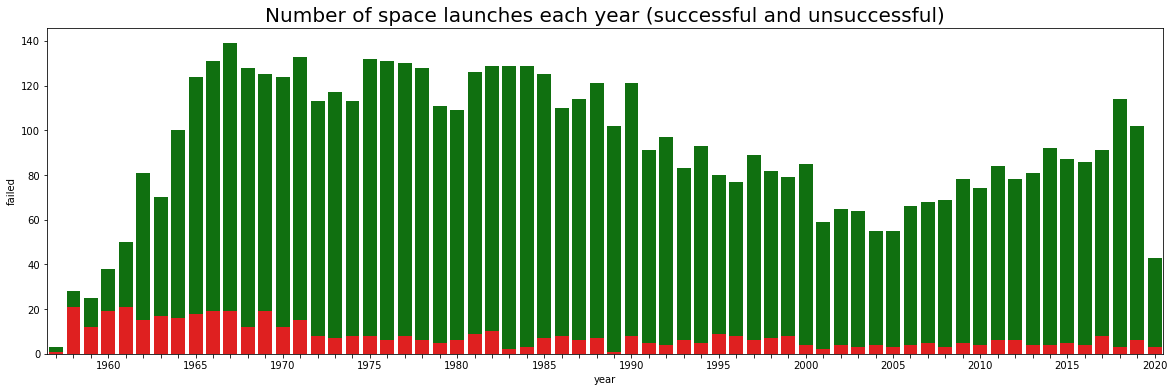

In [29]:
#Let's analize the error/success rate each year
fig = plt.figure(figsize=(20,6))

ax = sns.barplot(x="year",y="launches",data=countries_year,color="green")
sns.barplot(x="year",y="failed",data=countries_year,color="red",ax=ax)

#ax.legend(countries_year,["A","B"])
ax.set_xticklabels([year if year%5==0 else "" for year in countries_year["year"]])
ax.set_title("Number of space launches each year (successful and unsuccessful)", fontsize=20)

# Access to space

Now, to visualize how access to space has grown lately, let's go back to our original table, group by month and year and count the different countries that launched to space in that month. After that, we'll build a pivot table, and plot the different countries launching from their soil in a heatmap, and the number of nations puting satellites in orbit.

Text(0.5, 1.0, 'Different nations putting payloads in orbit each year')

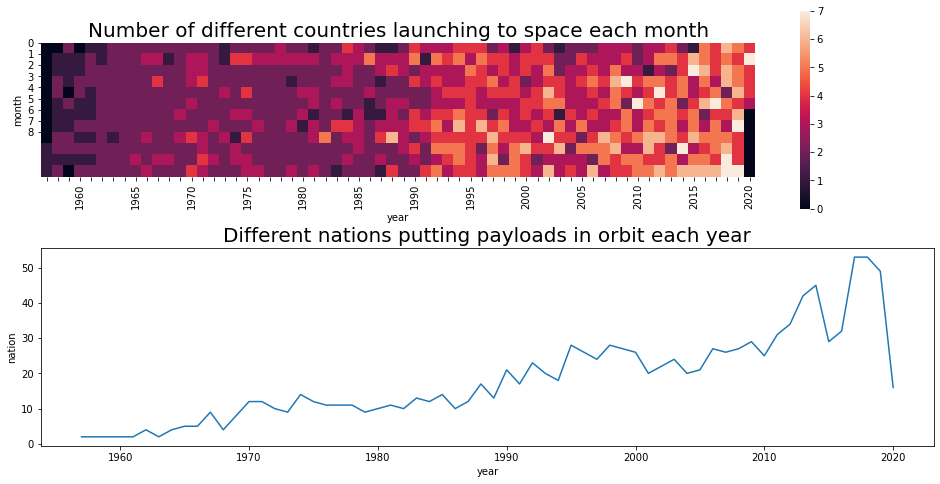

In [31]:
launches_per_month = unique_launches.groupby( ["year","month"] ).agg({"country":"count"}).reset_index()

countries_per_month = unique_launches.groupby( ["year","month"] ).agg({"country":"nunique"}).reset_index()
countries_per_month.head()
country_month_pivot_table = countries_per_month.pivot("month","year","country").fillna(0)

launches_per_month = unique_launches.groupby( ["year","month"] ).agg({"country":"count"}).reset_index()
launches_month_pivot_table = countries_per_month.pivot("month","year","country").fillna(0)

nation_payloads_year = joined.groupby(["year"],as_index=False).agg({'nation': 'nunique'})

fig,(ax,ax2) = plt.subplots(2,1,figsize=(16,8))
sns.heatmap(country_month_pivot_table,ax=ax, square=True,yticklabels=False)
sns.lineplot(x="year",y="nation",data=nation_payloads_year,ax=ax2,legend="full")

ax.set_xticklabels([year if year%5==0 else "" for year in countries_year["year"]])
ax.set_title("Number of different countries launching to space each month",fontsize=20)
ax.set_yticklabels([0, 1,2,3,4,5,6,7,8])
ax.yaxis.set_ticks([ 0, 1,2,3,4,5,6,7,8])

ax2.set_title("Different nations putting payloads in orbit each year",fontsize=20)



Let's see how many different countries have launched from their territory, and how often:


In [75]:
country_launches = unique_launches.groupby("country").agg({"year":["min", "max"],"type":"count"}).reset_index()
country_launches.columns = ['-'.join(col) for col in country_launches.columns.values]
country_launches = country_launches.rename({"type-count":"launches","country-":"country","year-min":"first_launch_year","year-max":"last_launch_year"},axis=1)
country_launches["yearly_rate_since_first"] = country_launches["launches"] / (2020-country_launches["first_launch_year"])
country_launches.sort_values("first_launch_year",ascending=False)

,country,first_launch_year,last_launch_year,launches,yearly_rate_since_first
13,New Zealand,2017,2020,12,4.000000
16,South Korea,2009,2013,3,0.272727
7,Iran,2008,2020,13,1.083333
12,Marshall Islands,2000,2012,9,0.450000
6,International,1999,2014,36,1.714286
14,North Korea,1998,2016,5,0.227273
2,Brazil,1997,2003,3,0.130435
17,Spain,1997,1997,1,0.043478
11,Kazakhstan,1992,2020,539,19.250000
15,Russia,1992,2020,277,9.892857


Most countries don't seem to stick to their programs, or develop their acquired capabilities, since many countries in this list only have a handful of launches . Algeria stopped being a French colony in 1962, but maybe the launches in '65 were from a French site? That requires some research. What about the last time a country launched to space?


In [77]:
country_launches.sort_values("last_launch_year",ascending=False)

,country,first_launch_year,last_launch_year,launches,yearly_rate_since_first
10,Japan,1966,2020,122,2.259259
3,China,1970,2020,361,7.220000
4,France,1970,2020,299,5.980000
7,Iran,2008,2020,13,1.083333
18,USA,1957,2020,1720,27.301587
11,Kazakhstan,1992,2020,539,19.250000
13,New Zealand,2017,2020,12,4.000000
15,Russia,1992,2020,277,9.892857
5,India,1979,2019,74,1.804878
8,Israel,1988,2016,10,0.312500


Time to look at the data but grouping by country: let's see what countries have launched to space in the different decades. We'll draw several heatmaps, one for each quarter century, and see how the information has changed over time.

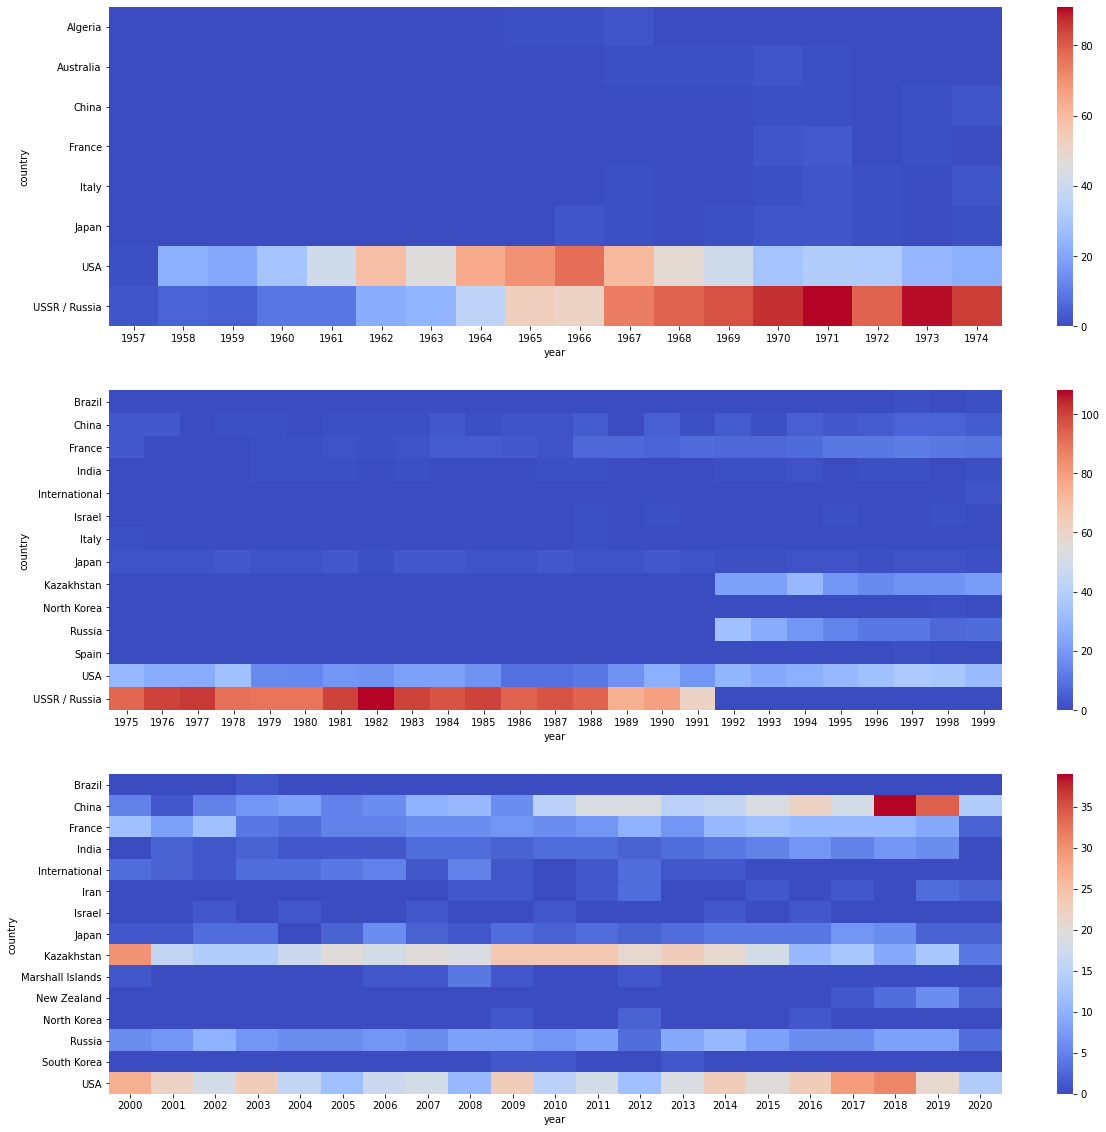

In [68]:
decade_tables = []
years = [1950,1975,2000]
fig, axes = plt.subplots(len(years),1,figsize=(20,20))

for i,year in enumerate(years):
    decade_group = unique_launches[ (unique_launches["year"]>=year) & (unique_launches["year"]<year+25) ].groupby(["country","year"])
    decade_pivot_table = decade_group.agg({"month":"count"}).reset_index().pivot("country","year","month")
    decade_tables.append( decade_pivot_table.fillna(0 ) )
    sns.heatmap(decade_pivot_table.fillna(0),ax=axes[i], cmap="coolwarm")                                                                     



We can see the trend we saw earlier reflected here as well: before the collapse of the Soviet Union, a great number of launches that died down. The number of launches from the US stays steady, and China really picks up the pace late this past decade. If the countries are grouped more conveniently, it's possible to plot this in a line chart to see the countries with the most launches more clearly.

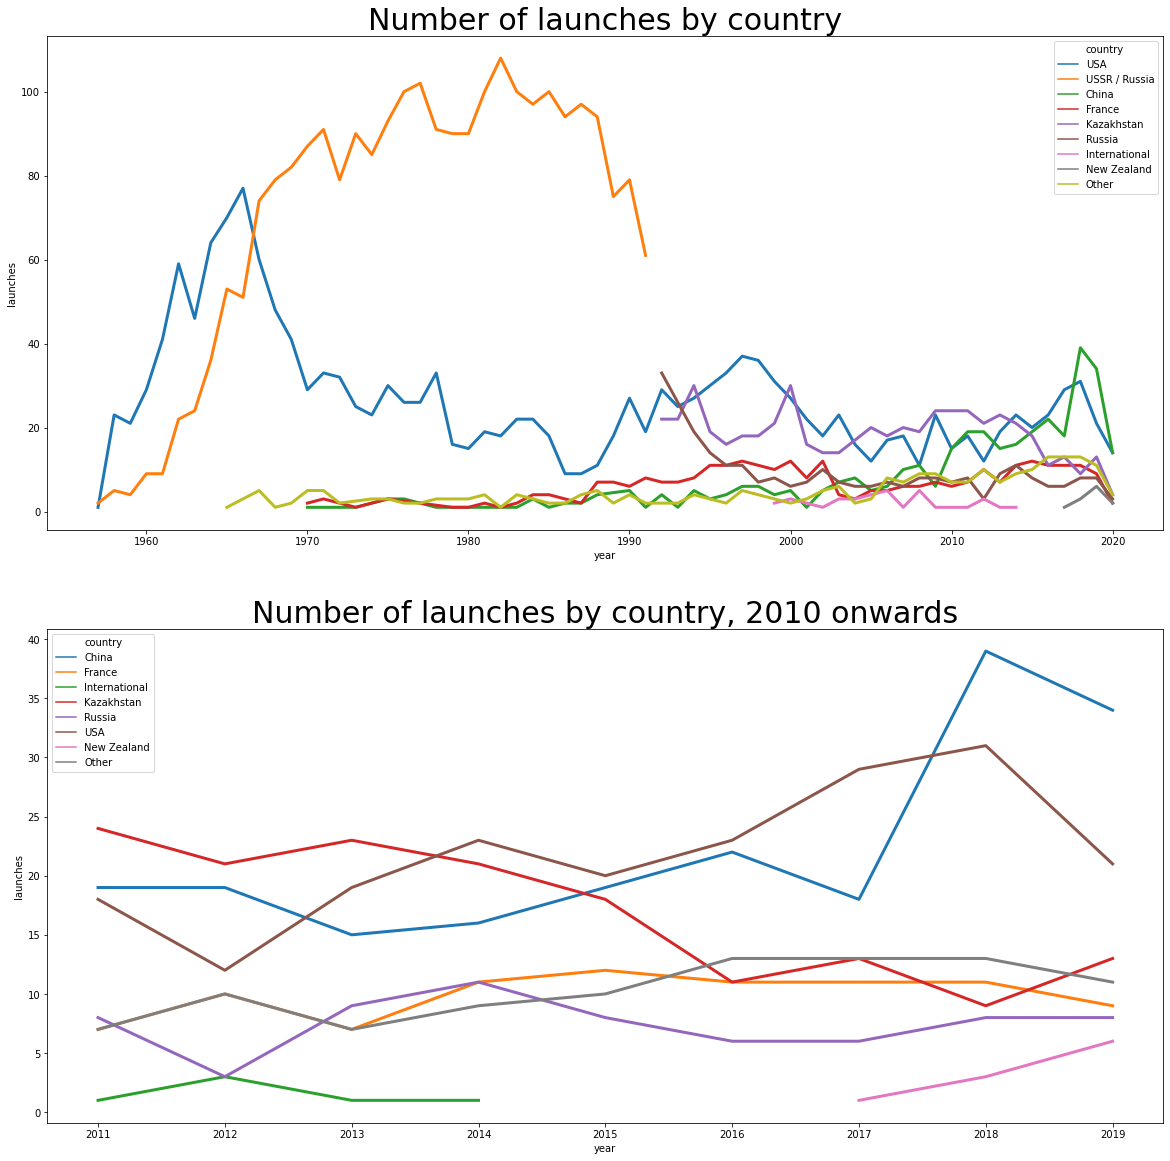

In [69]:
countries = unique_launches.groupby( ["year","country"] ).size().reset_index().rename({0:"launches"},axis=1)
top_countries = countries.groupby("country").mean().sort_values("launches", ascending=False).head(8).index

countries["is_top"] =  countries["country"].isin(top_countries)

other_countries = countries[ countries["is_top"]==False ].groupby("year").sum().reset_index()[ ["year","launches"] ]
other_countries["country"] = "Other"

all_countries = pd.concat( [ countries[ countries["country"].isin(top_countries) ][ ["year","launches","country"] ],other_countries] )

fig, axes = plt.subplots(2,1,figsize=(20,20))

axes[0].set_title("Number of launches by country",fontsize=30)
axes[1].set_title("Number of launches by country, 2010 onwards",fontsize=30)
sns.lineplot(x="year",y="launches",hue="country",data=all_countries,ax=axes[0], lw=3)
sns.lineplot(x="year",y="launches",hue="country",data=all_countries[ (all_countries["year"]>2010) & (all_countries["year"]<2020)] ,ax=axes[1], lw=3)



## Launch vehicles, number of satellites per launch

One last look at our data: what about the number of satellites being put to space? Let's try visualizing how many satellites get to space each year. We'll plot the number of launches, the year, and the total number of satellites each year, and also visualize the number of different space vehicles employed each year. That will give us some insight about how the private sector is beginning to form the space industry

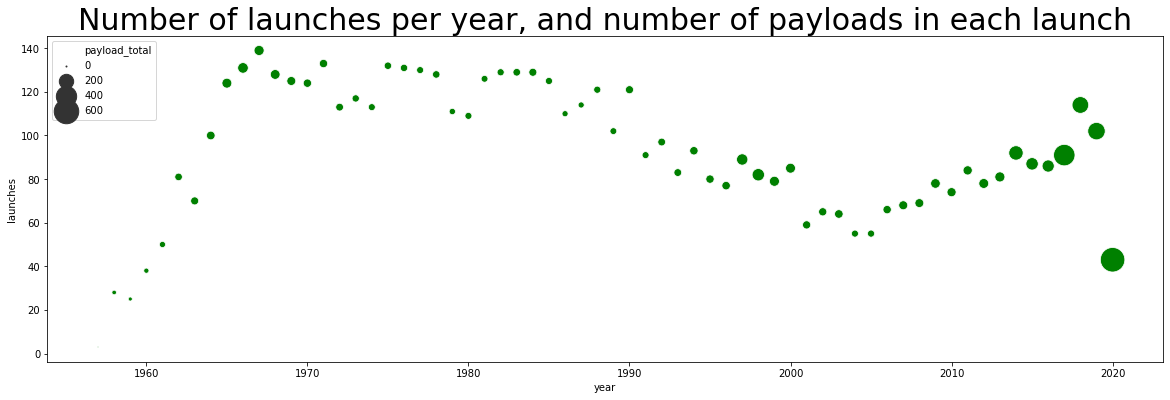

In [71]:
fig, (ax) = plt.subplots(1,1,figsize=(20,6))
#sns.scatterplot(x="year",y="country", size="country", hue="nation", data=countries_year)
ax.set_title("Number of launches per year, and number of payloads in each launch",fontsize=30)
sns.scatterplot(x="year",y="launches", size="payload_total", color="green", palette="coolwarm", data=countries_year,ax=ax, sizes=(1,600), marker="o")
fig.show()


A perhaps better way to visualize this is to plot the payload divided by the number of launches. 

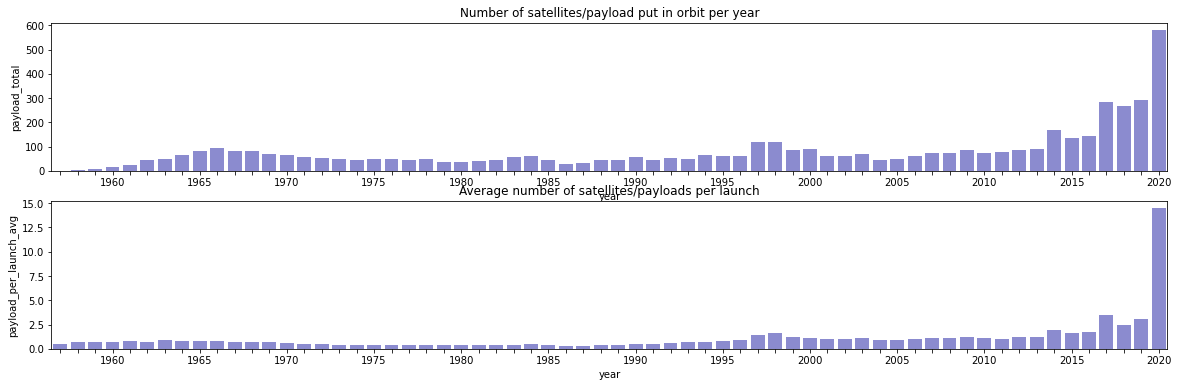

In [73]:
#Let's start plotting the number of launches we had each year, and how many different countries launched into space.
#We'll also plot how many different vehicles were used each year.
fig, (ax,ax2) = plt.subplots(2,1,figsize=(20,6))
#sns.scatterplot(x="year",y="country", size="country", hue="nation", data=countries_year)
ax.set_title("Number of satellites/payload put in orbit per year")
successful_countries_year["payload_per_launch_avg"] = successful_countries_year["payload_total"] / successful_countries_year["launches"]

chart = sns.barplot(x="year",y="payload_total", data=successful_countries_year,ax=ax,color="#8080DA")
ax.set_xticklabels([year if year%5==0 else "" for year in countries_year["year"]])

ax2.set_title("Average number of satellites/payloads per launch")
chart = sns.barplot(x="year",y="payload_per_launch_avg", data=successful_countries_year,ax=ax2,color="#8080DA")
ax2.set_xticklabels([year if year%5==0 else "" for year in countries_year["year"]])

fig.show()


There was some increase before the introduction of Starlink by SpaceX, but so far in 2020, the difference has been staggering.

# What we've learned, and what's next

After putting our data in order, we extracted a few interesting insights:

* We learned that peak of launches happened in the Cold War, driven mainly by the then USSR.
* Launches have increased in pace this past decade, with China specially active.
* Not many other countries have acquired launch capabilities. Only Iran, South Korea, and New Zealand, since the year 2000. (The Marshall islands launch site belongs to the United States). 
* Many countries are unable to sustain the pace of launches once they get to orbit. However, more research and domain knowledge is needed there: after further research, the 1997 launch from Spain consisted in launching a rocket from an aircraft, that took off from Gran Canaria. There might be some other cases similar to that one.
* However, the number of different countries placing payloads in orbit increased markedly, specially in these past 15 years. The last few years saw 50 different countries consistently putting at least a satellite in orbit.

What would we like to find out next? There are many interesting questions that can answer with this data, if we properly handle the columns that were disregarded. Furthermore, after our initial dive, some other questions arise:

* What's the use of the satellites currently in space? (military, techonology)
* What's the average mass of the payloads in orbit? Satellites supposedly got smaller these last few years.
* What about private companies? Can we tell when they started launching into space?
* What's the most reliable launch vehicle?
* It would be nice to visualize some of this information in a map.
* Do we have any information about humans in space in our data?
* What about the launch vehicles employed? What are the different methods of launching payloads to space?